In [ ]:
import pickle
import pandas as pd

# Load the optimization results
res = pickle.load(open('C:/Users/Dell/projects/regional_flex/results/full_year5.pkl', 'rb'))

# Extract metadata and regional summaries
meta = pd.DataFrame({
    'status': [res['status']],
    'objective_value': [res['objective_value']]
})

# Regional summary
regional_summary = pd.DataFrame(res['regional_summary']).T

# Slack usage
slack_usage = pd.DataFrame(res['slack_usage']).T

# Build dispatch, storage, DR, slack tables
dispatch_df = regional_summary['total_dispatch'].apply(pd.Series).add_prefix('dispatch_')
charge_df = regional_summary['total_storage_charge'].apply(pd.Series).add_prefix('charge_')
discharge_df = regional_summary['total_storage_discharge'].apply(pd.Series).add_prefix('discharge_')
dr_df = regional_summary['demand_response'].apply(pd.Series).add_prefix('dr_')
slack_df = slack_usage.add_prefix('slack_')

# Consolidated summary
summary_df = pd.concat([dispatch_df, charge_df, discharge_df, dr_df, slack_df], axis=1)

# Display results
print("Statut et Valeur objective")
print(meta)
print("\nRésumé Régional Annuel")
print(summary_df)



Statut et Valeur objective
       status                                    objective_value
0  Infeasible  <bound method LpAffineExpression.value of 25.0...

Résumé Régional Annuel
                            dispatch_hydro  dispatch_nuclear  \
Auvergne_Rhone_Alpes          1.266602e+08      3.298048e+05   
Nouvelle_Aquitaine            3.863025e+07      4.340391e+07   
Occitanie                     7.160334e+07      1.760294e+06   
Provence_Alpes_Cote_d'Azur    8.156759e+07      0.000000e+00   

                            dispatch_thermal_gas  dispatch_thermal_coal  \
Auvergne_Rhone_Alpes                         0.0                    0.0   
Nouvelle_Aquitaine                           0.0                    0.0   
Occitanie                                    0.0                    0.0   
Provence_Alpes_Cote_d'Azur                   0.0                    0.0   

                            dispatch_biofuel   charge_STEP  charge_batteries  \
Auvergne_Rhone_Alpes                     0

In [11]:
import pickle
import pandas as pd

# 1) Charge le résultat brute
res = pickle.load(open('C:/Users/Dell/projects/regional_flex/results/full_year5.pkl', 'rb'))

# 2) Construit le DataFrame time‑series
# Chaque clé de res['variables'] est un nom de variable, et la valeur est un dict t→valeur
# On convertit en Series pandas, on les aligne sur l'index temporel, et on concatène.
# On suppose ici résolution 30 minutes sur toute l’année 2022.
first_var = next(iter(res['variables'].values()))
n_steps = len(first_var)
index = pd.date_range('2022-01-01', periods=n_steps, freq='30min')

df = pd.DataFrame({
    var_name: pd.Series(var_dict).set_axis(index)
    for var_name, var_dict in res['variables'].items()
})

# 3) Vérifie que df n’est plus vide et qu’il contient des données
print(df.head())
print(df.shape)

# 4) Exporte vers CSV
df.to_csv('all_results_timeseries_full5.csv')
print("Exporté dans all_results_timeseries_full5.csv")


                     dispatch_hydro_Auvergne_Rhone_Alpes  \
2022-01-01 00:00:00                                0.000   
2022-01-01 00:30:00                               34.209   
2022-01-01 01:00:00                               68.418   
2022-01-01 01:30:00                              102.627   
2022-01-01 02:00:00                              136.836   

                     dispatch_nuclear_Auvergne_Rhone_Alpes  \
2022-01-01 00:00:00                                  0.000   
2022-01-01 00:30:00                                  6.815   
2022-01-01 01:00:00                                 13.630   
2022-01-01 01:30:00                                 20.445   
2022-01-01 02:00:00                                 27.260   

                     dispatch_thermal_gas_Auvergne_Rhone_Alpes  \
2022-01-01 00:00:00                                        0.0   
2022-01-01 00:30:00                                        0.0   
2022-01-01 01:00:00                                        0.0   
20

Régions détectées : ['Aquitaine_Occitanie', "Aquitaine_Provence_Alpes_Cote_d'Azur", 'Auvergne_Rhone_Alpes', 'Nouvelle_Aquitaine', 'Occitanie', "Provence_Alpes_Cote_d'Azur", 'Rhone_Alpes_Nouvelle_Aquitaine', 'Rhone_Alpes_Occitanie', "Rhone_Alpes_Provence_Alpes_Cote_d'Azur", 'coal_Auvergne_Rhone_Alpes', 'coal_Nouvelle_Aquitaine', 'coal_Occitanie', "coal_Provence_Alpes_Cote_d'Azur", 'gas_Auvergne_Rhone_Alpes', 'gas_Nouvelle_Aquitaine', 'gas_Occitanie', "gas_Provence_Alpes_Cote_d'Azur"]
## Région : Aquitaine_Occitanie



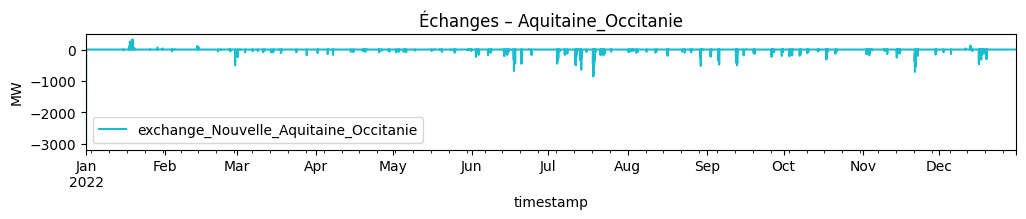



## Région : Aquitaine_Provence_Alpes_Cote_d'Azur



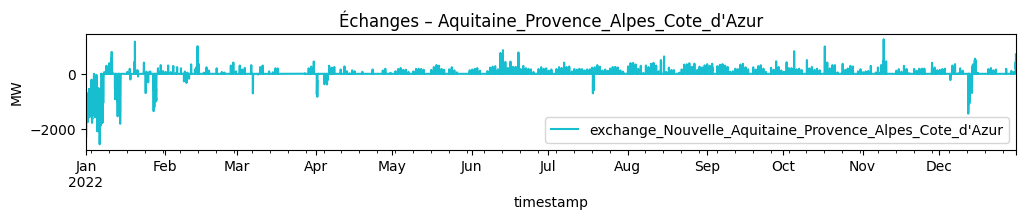



## Région : Auvergne_Rhone_Alpes



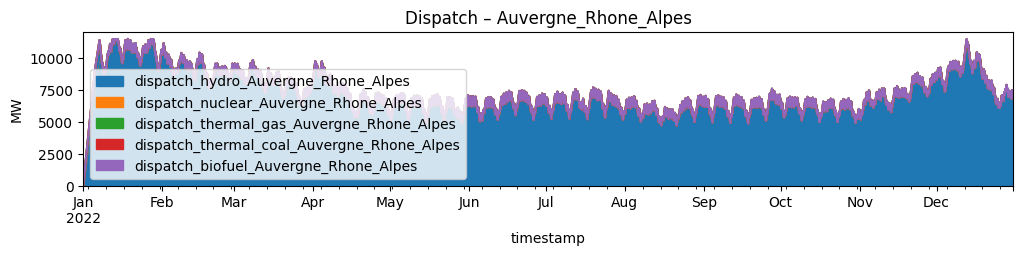

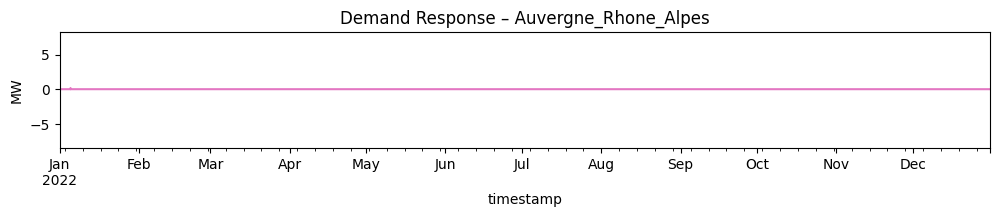

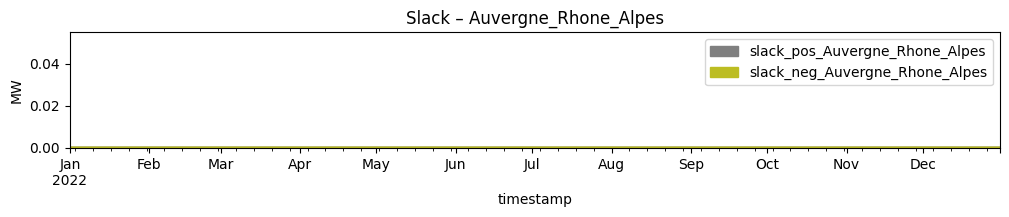

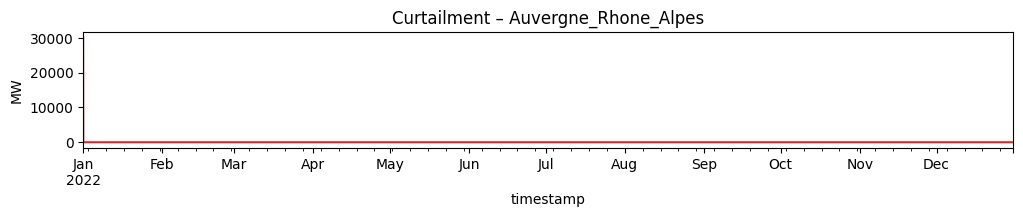



## Région : Nouvelle_Aquitaine



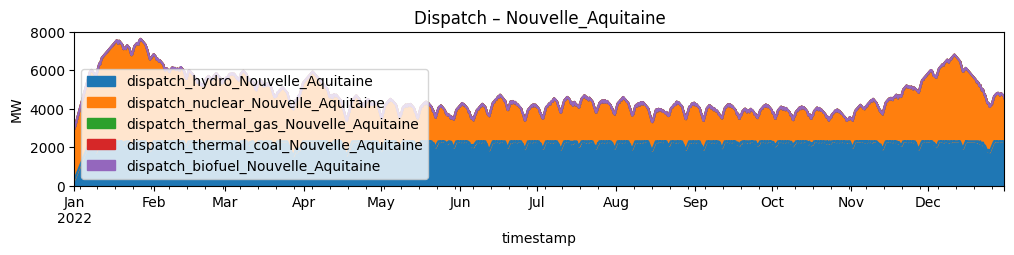

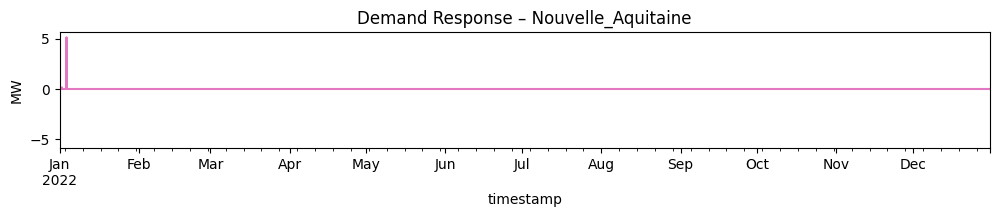

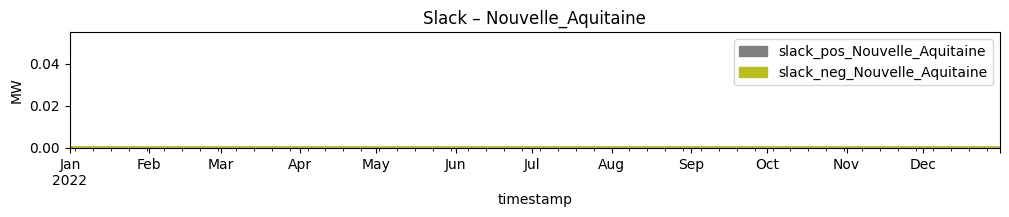

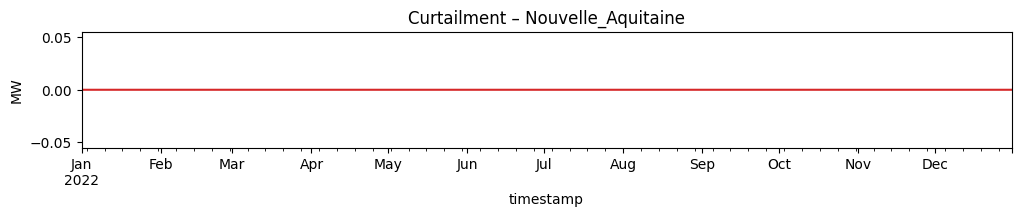

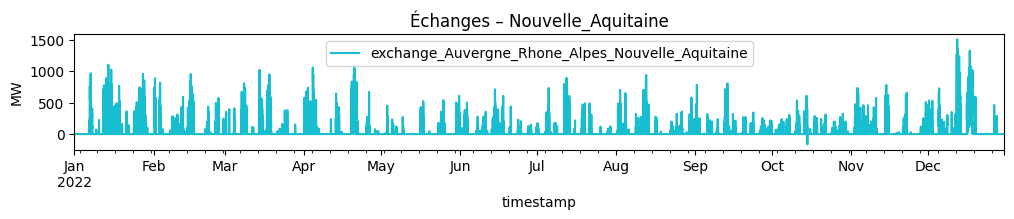



## Région : Occitanie



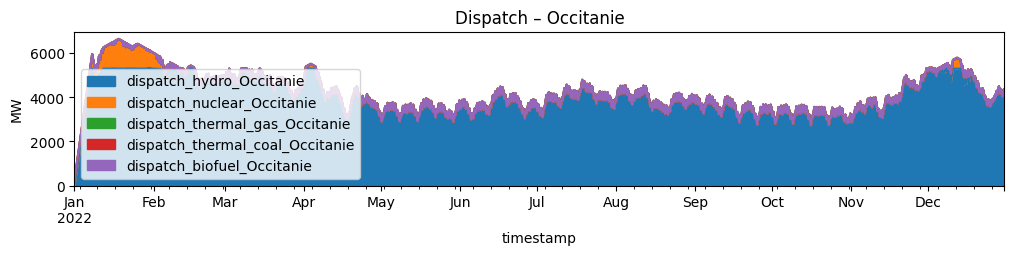

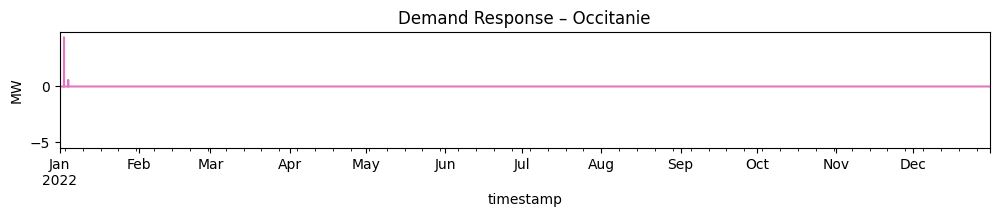

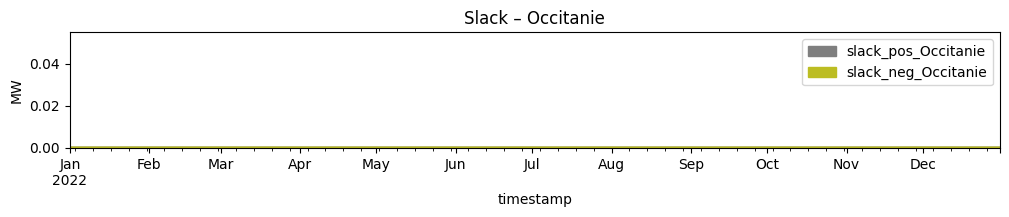

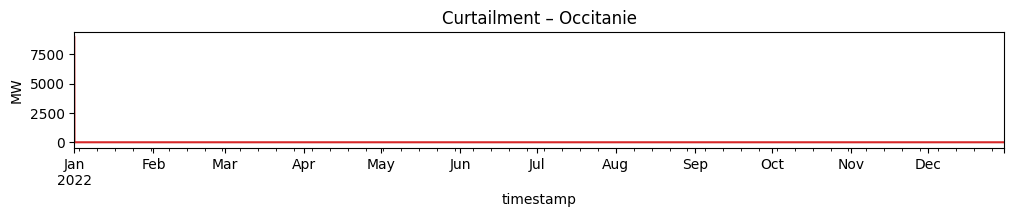

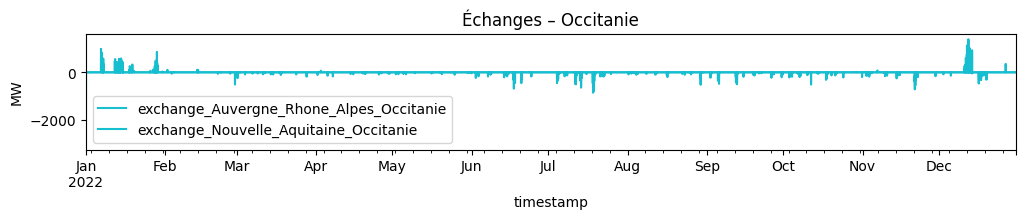



## Région : Provence_Alpes_Cote_d'Azur



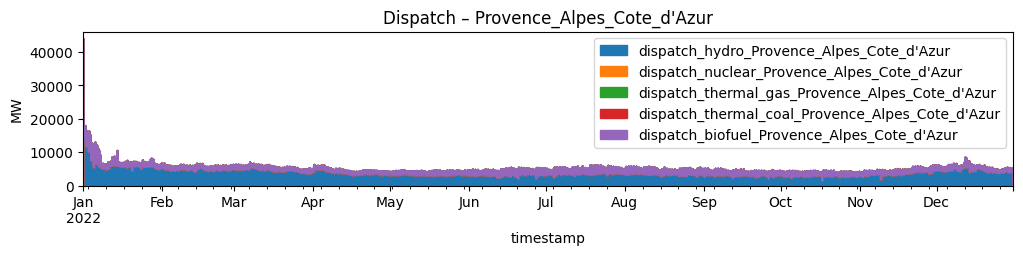

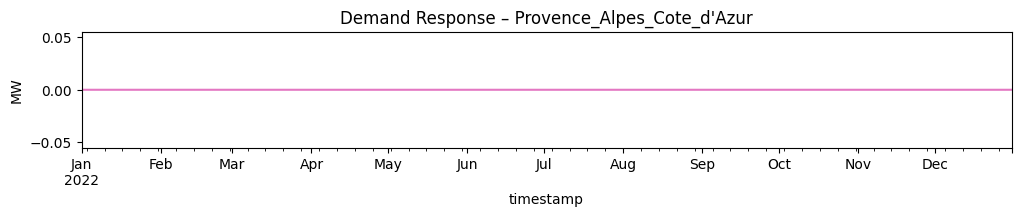

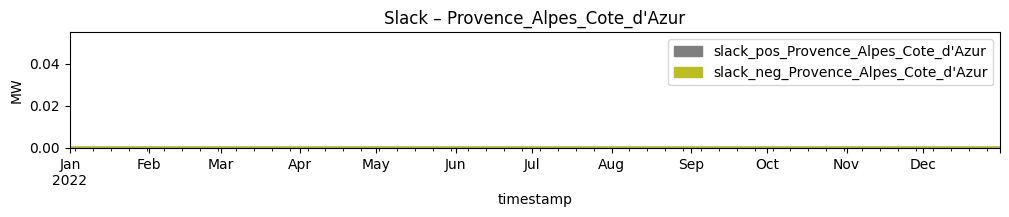

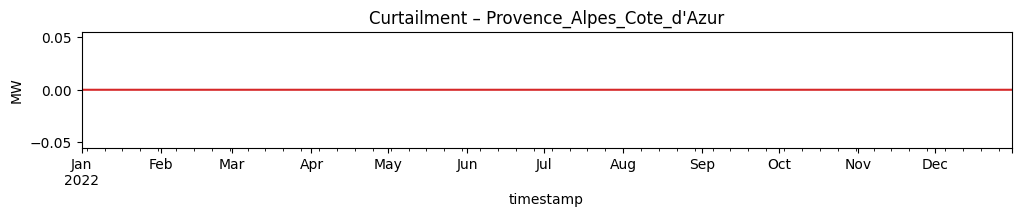

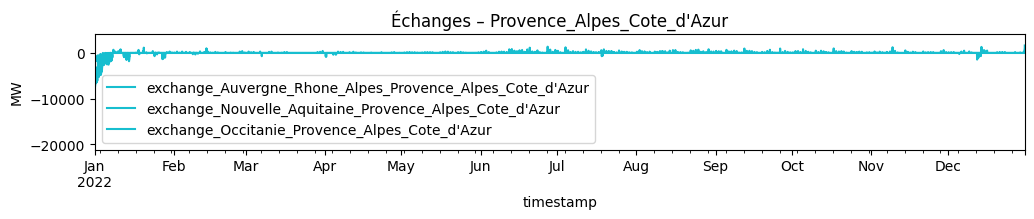



## Région : Rhone_Alpes_Nouvelle_Aquitaine



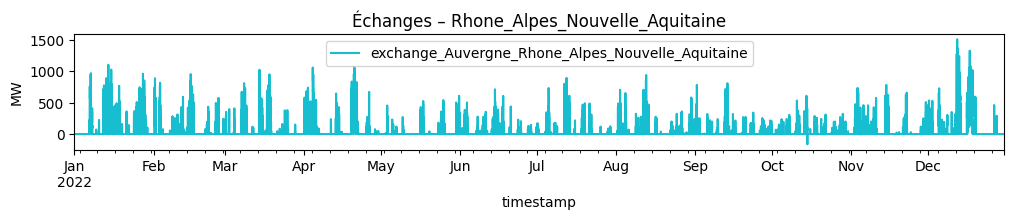



## Région : Rhone_Alpes_Occitanie



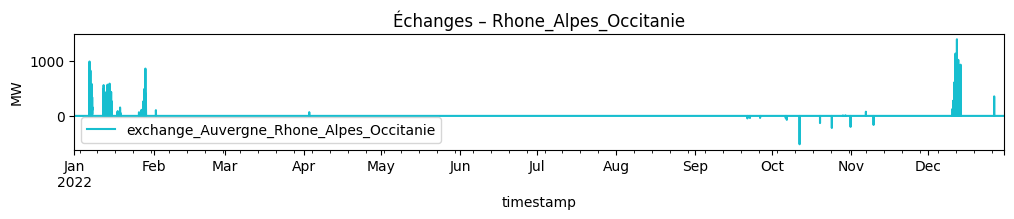



## Région : Rhone_Alpes_Provence_Alpes_Cote_d'Azur



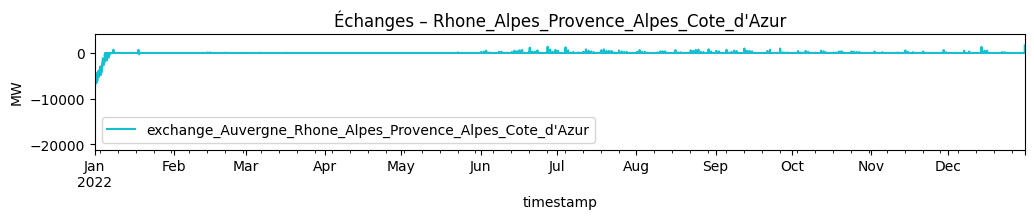



## Région : coal_Auvergne_Rhone_Alpes



KeyError: 'dispatch_thermal'

In [14]:
# Cell 1 – Charger les données et extraire la liste des régions
import pandas as pd
import matplotlib.pyplot as plt
import re

# Charger le CSV
df = pd.read_csv('all_results_timeseries_full5.csv', parse_dates=['timestamp'], index_col='timestamp')

# Détecter automatiquement les régions à partir des noms de colonnes
regions = set()
patterns = [
    r'^dispatch_[^_]+_(.+)$',
    r'^charge_[^_]+_(.+)$',
    r'^discharge_[^_]+_(.+)$',
    r'^demand_response_(.+)$',
    r'^curtail_(.+)$',
    r'^exchange_[^_]+_(.+)$',
    r'^slack_pos_(.+)$',
    r'^slack_neg_(.+)$'
]
for col in df.columns:
    for pat in patterns:
        m = re.match(pat, col)
        if m:
            regions.add(m.group(1))
regions = sorted(regions)
print("Régions détectées :", regions)

# Cell 2 – Palette de couleurs partagée
PALETTE = {
    'dispatch_hydro':      '#1f77b4',
    'dispatch_nuclear':    '#ff7f0e',
    'dispatch_thermal_gas': '#2ca02c',
    'dispatch_thermal_coal':'#d62728',
    'dispatch_biofuel':    '#9467bd',
    'charge_STEP':         '#17becf',
    'charge_batteries':    '#8c564b',
    'discharge_STEP':      '#7f7f7f',
    'discharge_batteries': '#bcbd22',
    'demand_response':     '#e377c2',
    'slack_pos':           '#7f7f7f',
    'slack_neg':           '#bcbd22',
    'exchange':            '#17becf',
    'curtail':             '#d62728'
}

# Cell 3 – Boucle de visualisation pour chaque région
for region in regions:
    print(f"## Région : {region}\n")
    
    # Dispatch empilé
    disp_cols = [c for c in df.columns if c.startswith('dispatch_') and c.endswith(f"_{region}")]
    if disp_cols:
        df_disp = df[disp_cols]
        colors = [PALETTE[col.replace(f"_{region}",'')] for col in df_disp.columns]
        ax = df_disp.plot.area(stacked=True, figsize=(12,2), color=colors)
        ax.set_title(f"Dispatch – {region}")
        ax.set_ylabel("MW")
        plt.show()
    
    # Puissances de charge / décharge stockage
    ch_cols = [c for c in df.columns if c.startswith('charge_') and c.endswith(f"_{region}")]
    dch_cols = [c for c in df.columns if c.startswith('discharge_') and c.endswith(f"_{region}")]
    if ch_cols or dch_cols:
        fig, axes = plt.subplots(1,2, figsize=(12,2), sharey=True)
        if ch_cols:
            df[ch_cols].plot.area(ax=axes[0], stacked=True, color=[PALETTE[col.replace('_'+region,'')] for col in ch_cols])
            axes[0].set_title("Charge stockage")
            axes[0].set_ylabel("MW")
        if dch_cols:
            df[dch_cols].plot.area(ax=axes[1], stacked=True, color=[PALETTE[col.replace('_'+region,'')] for col in dch_cols])
            axes[1].set_title("Décharge stockage")
        plt.suptitle(f"Stockage – {region}")
        plt.tight_layout(rect=[0,0,1,0.95])
        plt.show()
    
    # Demand Response
    dr_col = f"demand_response_{region}"
    if dr_col in df:
        ax = df[dr_col].plot(figsize=(12,1.5), color=PALETTE['demand_response'])
        ax.set_title(f"Demand Response – {region}")
        ax.set_ylabel("MW")
        plt.show()
    
    # Slack + / -
    slack_pos = f"slack_pos_{region}"
    slack_neg = f"slack_neg_{region}"
    if slack_pos in df and slack_neg in df:
        df[[slack_pos, slack_neg]].plot.area(stacked=True, figsize=(12,1.5),
                                             color=[PALETTE['slack_pos'], PALETTE['slack_neg']])
        plt.title(f"Slack – {region}")
        plt.ylabel("MW")
        plt.show()
    
    # Curtailment
    cur_col = f"curtail_{region}"
    if cur_col in df:
        df[cur_col].plot(figsize=(12,1.5), color=PALETTE['curtail'])
        plt.title(f"Curtailment – {region}")
        plt.ylabel("MW")
        plt.show()
    
    # Échanges
    ex_cols = [c for c in df.columns if c.startswith('exchange_') and c.endswith(f"_{region}")]
    if ex_cols:
        df[ex_cols].plot(figsize=(12,1.5), color=[PALETTE['exchange']]*len(ex_cols))
        plt.title(f"Échanges – {region}")
        plt.ylabel("MW")
        plt.show()
    
    print("\n")

